In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
import xgboost as xgb
import shap

In [3]:
df = pd.read_csv('train.csv')

In [4]:
df.head()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,choose
0,0,35.0,0.0,2150.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,74.0,0
1,1,52.0,2.0,1250.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,57.0,1
2,2,29.0,3.0,1750.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,66.0,0
3,3,33.0,3.0,1050.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,66.0,1
4,4,46.0,3.0,2250.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,73.0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   10000 non-null  int64  
 1   age                  10000 non-null  float64
 2   years_of_experience  10000 non-null  float64
 3   lesson_price         10000 non-null  float64
 4   qualification        10000 non-null  float64
 5   physics              10000 non-null  float64
 6   chemistry            10000 non-null  float64
 7   biology              10000 non-null  float64
 8   english              10000 non-null  float64
 9   geography            10000 non-null  float64
 10  history              10000 non-null  float64
 11  mean_exam_points     10000 non-null  float64
 12  choose               10000 non-null  int64  
dtypes: float64(11), int64(2)
memory usage: 1015.8 KB


In [6]:
df.describe()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,choose
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,4999.50000,45.800900,1.974800,1702.440000,1.724300,0.37060,0.121500,0.117200,0.059100,0.02770,0.018000,64.435200,0.110900
std,2886.89568,8.030274,1.766883,523.789062,0.798845,0.48299,0.326724,0.321675,0.235824,0.16412,0.132958,13.595024,0.314024
min,0.00000,23.000000,0.000000,200.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,33.000000,0.000000
25%,2499.75000,40.000000,0.000000,1300.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,55.000000,0.000000
50%,4999.50000,46.000000,2.000000,1550.000000,2.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,63.000000,0.000000
75%,7499.25000,51.000000,3.000000,2150.000000,2.000000,1.00000,0.000000,0.000000,0.000000,0.00000,0.000000,74.000000,0.000000
max,9999.00000,68.000000,9.000000,3950.000000,4.000000,1.00000,1.000000,1.000000,1.000000,1.00000,1.000000,100.000000,1.000000


In [7]:
continuous_columns = ["age", "years_of_experience", 'lesson_price', 'qualification', 'mean_exam_points']
target = 'choose'

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df[continuous_columns], df[target], random_state=42)

In [9]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]
    

    
continuous_columns = ["age", "years_of_experience", 'lesson_price', 'qualification', 'mean_exam_points']
final_transformers = list()
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('scaler', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))
    
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

In [10]:
regressor = Pipeline([
    ('features',feats),
    ('classifier', xgb.XGBRegressor()),
])

#обучим наш пайплайн
regressor.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('age',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='age')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('years_of_experience',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='years_of_experience')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('lesson_price',
                                                 Pipeline(steps=[('selector',
            

In [11]:
predictions =  regressor.predict(X_test)

In [12]:
xgb_features = pd.DataFrame(regressor[1].feature_importances_, 
                        continuous_columns, 
                        columns=['coefficient'])
xgb_features.head()

,coefficient
age,0.137733
years_of_experience,0.140460
lesson_price,0.235512
qualification,0.242204
mean_exam_points,0.244091


In [15]:
model = xgb.train({"learning_rate": 0.01}, 
                      xgb.DMatrix(X_train, label=y_train), 100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

График выше показывает вклад каждого признака в предсказание модели относительно базового значения (средний прогноз по всему тренировочному набору данных). 

- Цвет точки - это значение признака
- То, насколько точка далека от вертикальной линии (серой) влево - показывает ее вклад как отрицательный
- То, насколько точка далека от вертикальной линии (серой) вправо - показывает ее положительный вклад

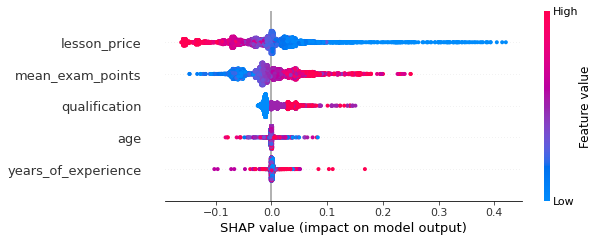

In [16]:
shap.summary_plot(shap_values, X_train)



значения слева от центральной вертикальной линии — это negative класс (0), справа — positive (1)
чем толще линия на графике, тем больше таких точек наблюдения
чем краснее точка на графике

чем выше средний балл и квалификация репетитора, тем выше вероятность выбора
чем выше стоимость за час, тем ниже шанс выбора

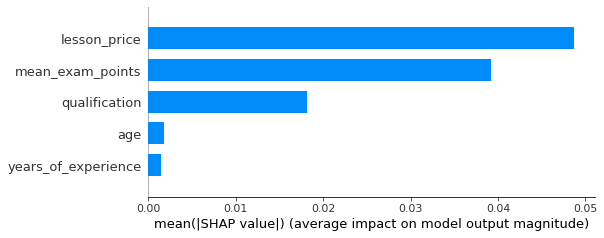

In [17]:
shap.summary_plot(shap_values, X_train, plot_type="bar")